# Chapter 6: k-Nearest Neighbors (k-NN)

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

## 6.1 Introduction & Motivation

As our final classical classifier, we'll explore the k-NN (k-Nearest Neighbors) algorithm. This approach is based on a very simple and logical idea: observations of the same class should resemble each other. In our digit examples, this definitely makes sense, but what does this concretely mean? And how can we tell a computer when things resemble each other?

This and much more is what we'll learn in this chapter! Excited yet?

**Key concept**: k-NN assumes that similar data points belong to the same class and are located close to each other in the feature space.

## 6.2 Problem Setting

Once again, we'll use the familiar digits dataset for our k-NN implementation. The setup should look familiar from previous chapters:

**Note**: We use consistent variable naming (X_train, X_test) following scikit-learn conventions where X represents features and y represents target labels.

In [35]:
digits = datasets.load_digits()
dir(digits)
# data
# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , digits.data.shape)
# Print to show there are 1797 labels (integers from 0–9)
print("Label Data Shape", digits.target.shape)
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
 plt.subplot(1, 5, index + 1)
 plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
 plt.title('Training: %i\n' % label, fontsize = 20)
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


## 6.3 Model

### 6.3.1 Model

In our digits database, the independent variables (pixel intensities) are difficult to visualize, so let's look at a simpler 2D dataset to understand how k-NN works conceptually:

![alt text](https://depiesml.files.wordpress.com/2015/08/knn_plot.png?w=600&h=586)

If we want a model to classify this type of data, we'll make use of one very important property of classes of data: **they cluster together in the right dimensions**. That is, in these two variables (F1 and F2), we can clearly see that all the points of the same class are bundled together. On average, we can say that if we take a random blue point, we're more likely to find another blue point nearby rather than a green or red one.

This is exactly what k-NN does: it takes a point we want to predict (for example, the grey point in the next image) and finds its nearest neighbors to make a classification decision.

![alt text](https://depiesml.files.wordpress.com/2015/08/knn-k5-initial1.png?w=600&h=586)

The k-NN algorithm then calculates the distance from the query point to all other points in the training set, and selects the $k$ nearest data points. 

**Note**: The most common distance metric used is Euclidean distance, but other metrics like Manhattan or Minkowski distance can also be used depending on the problem.

![](https://depiesml.files.wordpress.com/2015/08/knn-k5-neighbor.png)

These nearest neighbors then "vote" on which class we should predict for the query point. Different voting schemes are possible, but the most straightforward approach is **majority voting**: the class that is represented the most among the k nearest neighbors becomes the final prediction.

**Example**: If k=5 and we find 3 blue points, 1 red point, and 1 green point as the nearest neighbors, then the prediction would be "blue" since it has the majority vote.

### 6.3.2 Model Estimation

That all sounds straightforward enough, so let's put it into practice!
We'll create a 9-Nearest-Neighbors classifier and fit it to our training data:

**Note**: The choice of k=9 is arbitrary for now. We'll explore how to choose the optimal k value later in this chapter.

In [36]:
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

Next, we can make predictions in different ways:
- For a single observation (one image)
- For multiple observations at once
- For all observations in our test set

**Tip**: Notice how we need to reshape single observations using `.reshape(1,-1)` to match the expected input format for scikit-learn.

In [37]:
# Returns a NumPy Array
# Predict for One Observation (image)
neigh.predict(X_test[0].reshape(1,-1))
neigh.predict(X_test[0:10])
predictions = neigh.predict(X_test)

## 6.4 Model Evaluation

### 6.4.1 Accuracy

Let's start by evaluating our model's accuracy - the percentage of correct predictions:

In [38]:
# accuracy
# Use score method to get accuracy of model
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.9777777777777777


##### Question 1: Experiment with the n_neighbors parameter to find which model gives the highest accuracy. Interpret your findings! Explain what is happening in the model and how the choice of k influences accuracy. Is this behavior logical? Are there any constraints on this parameter?

**Hint**: Try different values of k and observe the pattern. Think about what happens when k is very small (like 1) versus when k is very large.

C:\Users\billo\AppData\Local\Temp\ipykernel_26104\2982199723.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


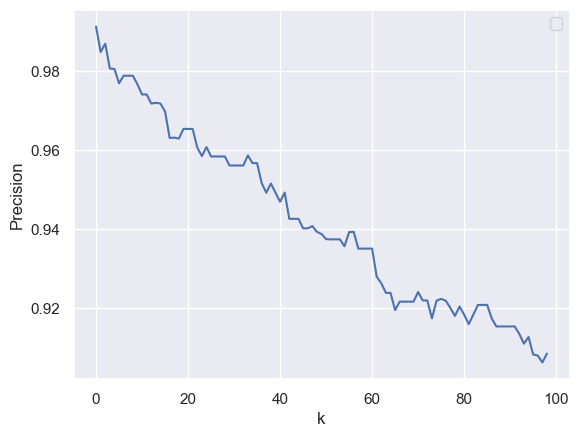

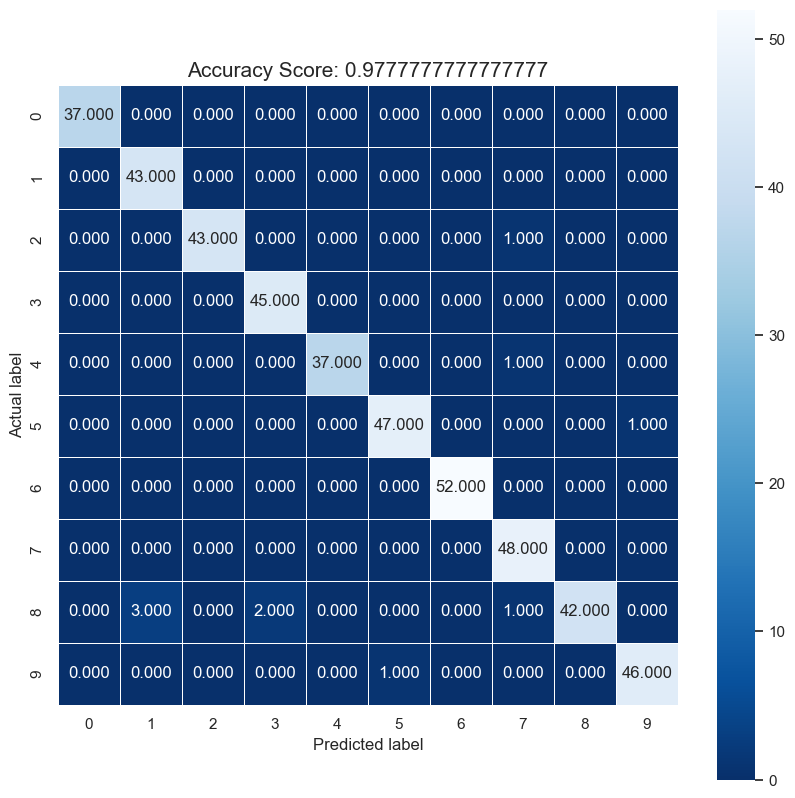

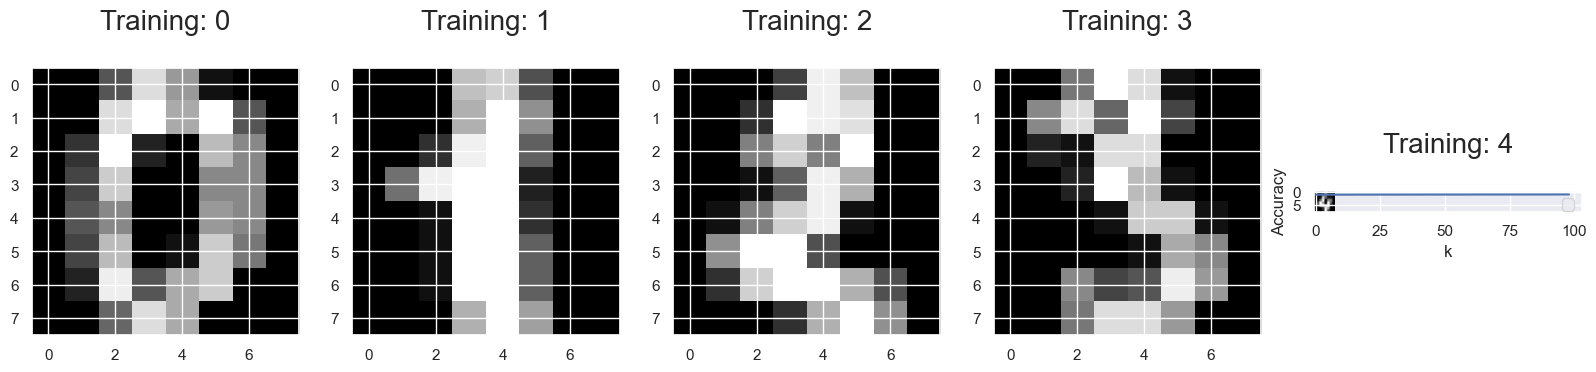

In [39]:
accuracies = []

for x in range (1, 100):
    neigh = KNeighborsClassifier(n_neighbors=x)
    neigh.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, neigh.predict(X_test)))

plt.plot(accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can observe a strong negative linear relationship between the value of k and accuracy. This is expected behavior. The higher the value of k, the more neighbors are voting on the final label. As k increases, we include neighbors that are farther away from our query point, making them more likely to belong to a different class, which leads to incorrect predictions.

**Important constraint**: In Python, we get an error starting at k = 1348. This is because our training set contains only 1347 digits. When k exceeds the number of training samples, there are no more neighbors available to vote, and Python throws an error.

**Key insight**: There's a trade-off with k - too small and the model is sensitive to noise (overfitting), too large and the model becomes too generalized (underfitting).

### 6.4.2 Precision

Now let's examine precision and other classification metrics using the classification report:

In [40]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.93      1.00      0.97        43
           2       1.00      0.98      0.99        44
           3       0.96      1.00      0.98        45
           4       1.00      0.97      0.99        38
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       0.94      1.00      0.97        48
           8       1.00      0.88      0.93        48
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



##### Question 2: Experiment with the n_neighbors parameter to see how it affects precision. Interpret your findings! Explain what is happening in the model and how the choice of k influences precision. Is this behavior logical?

**Remember**: Precision measures the proportion of positive predictions that were actually correct (true positives / (true positives + false positives)).

In [41]:
precisions = []

for x in range (1, 100):
    neigh = KNeighborsClassifier(n_neighbors=x)
    neigh.fit(X_train, y_train)
    precisions.append(precision_score(y_test, neigh.predict(X_test), average='weighted'))

plt.plot(precisions)
plt.xlabel("k")
plt.ylabel("Precision")
plt.legend()
print()

C:\Users\billo\AppData\Local\Temp\ipykernel_26104\3749711692.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Here we observe the exact same pattern: the higher our value of k, the lower our precision. This is expected behavior as our predictions become progressively worse when k increases too much.

**Insight**: Both accuracy and precision follow similar trends with respect to k, which makes sense since they're both measures of prediction quality.

### 6.4.3 Confusion Matrix

You should be familiar with the confusion matrix from previous chapters. Let's create one to visualize our model's performance:

##### Question 3: Create the confusion matrix and interpret it. What does it tell you about your model's performance?

**Reminder**: In a confusion matrix, the diagonal represents correct predictions, while off-diagonal elements represent misclassifications.

In [42]:
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train, y_train)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15);

This confusion matrix indicates that we have a really good model! We can see:

- **Strong diagonal**: High numbers along the diagonal indicate many correct predictions
- **Few off-diagonal values**: Very few misclassifications, which appear as small numbers outside the diagonal
- **Overall pattern**: The majority of our predictions are correct across all digit classes

**Interpretation tip**: Look for patterns in the misclassifications - are certain digits commonly confused with each other? This can provide insights into which digits are visually similar.

## 6.5 Exercises

##### Question 1: See section 6.4.1
##### Question 2: See section 6.4.2  
##### Question 3: See section 6.4.3
##### Question 4: Compare the optimal k-NN model to the optimal logistic regression and decision tree models from previous chapters. Which model do you prefer based on accuracy? Which model do you prefer based on precision? Which model would you choose overall? Is there an unambiguous choice to be made?

**Analysis framework**: Consider not just performance metrics, but also factors like:
- Model interpretability
- Training and prediction speed
- Overfitting tendencies
- Computational requirements

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [44]:
accuracies_log = []
accuracies_tree = []
accuracies_knn = []

for solver in ['lbfgs', 'saga', 'newton-cg']:
    for max_iter in [10, 100, 1000, 10000, 100000]:
        logisticRegr = LogisticRegression(max_iter=max_iter, solver=solver)
        logisticRegr.fit(X_train, y_train)
        accuracies_log.append(accuracy_score(y_test, logisticRegr.predict(X_test)))

for x in range (1, 101):
    model = DecisionTreeClassifier(max_depth = x)
    model.fit(X_train, y_train)
    accuracies_tree.append(accuracy_score(y_test, model.predict(X_test)))

for x in range (1, 100):
    neigh = KNeighborsClassifier(n_neighbors=x)
    neigh.fit(X_train, y_train)
    accuracies_knn.append(accuracy_score(y_test, neigh.predict(X_test)))

print('Logistic regression:', max(accuracies_log))
print('Decision trees:', max(accuracies_tree))
print('knn:', max(accuracies_knn))

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Logistic regression: 0.9622222222222222
Decision trees: 0.8666666666666667
knn: 0.9911111111111112


When comparing all optimal models, we can see that k-NN is the clear winner with the highest accuracy. This result makes intuitive sense because:

**Why k-NN performs well on digits**: 
- The digits dataset focuses on the visual/physical shape of handwritten numbers
- k-NN excels at pattern recognition by finding visually similar examples
- Predicting digit classes based on similarity to known examples aligns perfectly with how k-NN works

**Important considerations**:
However, we must be cautious about potential overfitting in our k-NN model. The high performance might be due to the model memorizing the training data rather than learning generalizable patterns. Further exploration using techniques like cross-validation would be needed to validate these results.

**Next steps**: Consider exploring techniques like:
- Cross-validation to assess generalization
- Feature scaling/normalization 
- Different distance metrics
- Ensemble methods combining multiple algorithms